In [1]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.manifold import TSNE

In [2]:
def load_pickle_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data


coh_base_dir = "../data/COH/"
pli_base_dir = "../data/PLI/"
ste_base_dir = "../data/STE/"


BD_coh  = load_pickle_data(coh_base_dir + "BD_coh_data.pkl")
BD_pli  = load_pickle_data(pli_base_dir + "BD_pli_data.pkl")
MDD_coh = load_pickle_data(coh_base_dir + "MDD_coh_data.pkl")
MDD_pli = load_pickle_data(pli_base_dir + "MDD_pli_data.pkl")
BD_ste  = load_pickle_data(ste_base_dir + "BD_ste_data.pkl")
MDD_ste = load_pickle_data(ste_base_dir + "MDD_ste_data.pkl")

In [3]:
def combine_features_all(subject_id, coh_dict, pli_dict, ste_dict):
    
    frequency_bands = ["delta", "theta", "alpha", "betalow", "betahigh", "gamma"]
    features = []
    # COH
    for band in frequency_bands:
        features.append(coh_dict[subject_id][band])
    # PLI
    for band in frequency_bands:
        features.append(pli_dict[subject_id][band])
    # STE
    for band in frequency_bands:
        matrix = ste_dict[subject_id][band] 
        mask = np.ones(matrix.shape, dtype=bool)
        np.fill_diagonal(mask, False)
        vector = matrix[mask] 
        features.append(vector)
    return np.concatenate(features)

In [4]:
BD_subjects = sorted(BD_coh.keys())
MDD_subjects = sorted(MDD_coh.keys())


n_train_BD = 45
n_train_MDD = 45

BD_train_ids = BD_subjects[:n_train_BD]
BD_test_ids  = BD_subjects[n_train_BD:]
MDD_train_ids = MDD_subjects[:n_train_MDD]
MDD_test_ids  = MDD_subjects[n_train_MDD:]


In [5]:
X_train_list = []
y_train_list = []
train_ids = []

for subj in BD_train_ids:
    feat_vector = combine_features_all(subj, BD_coh, BD_pli, BD_ste)
    X_train_list.append(feat_vector)
    y_train_list.append(0)    # BD = 0
    train_ids.append(subj)
for subj in MDD_train_ids:
    feat_vector = combine_features_all(subj, MDD_coh, MDD_pli, MDD_ste)
    X_train_list.append(feat_vector)
    y_train_list.append(1)    # MDD = 1
    train_ids.append(subj)

X_train = np.array(X_train_list)  # shape: (90, 9744)
y_train = np.array(y_train_list)
print("Training set data shape:", X_train.shape, y_train.shape)

Training set data shape: (90, 9744) (90,)


In [6]:
X_test_list = []
y_test_list = []
test_ids = []

for subj in BD_test_ids:
    feat_vector = combine_features_all(subj, BD_coh, BD_pli, BD_ste)
    X_test_list.append(feat_vector)
    y_test_list.append(0)
    test_ids.append(subj)
for subj in MDD_test_ids:
    feat_vector = combine_features_all(subj, MDD_coh, MDD_pli, MDD_ste)
    X_test_list.append(feat_vector)
    y_test_list.append(1)
    test_ids.append(subj)

X_test = np.array(X_test_list)    # shape: (39, 9744)
y_test = np.array(y_test_list)
print("Independent test set data shape:", X_test.shape, y_test.shape)

Independent test set data shape: (39, 9744) (39,)


In [7]:
def compute_fisher_scores(X, y, eps=1e-12):
    N = len(y)
    n_class0 = np.sum(y == 0)
    n_class1 = np.sum(y == 1)
    p0 = n_class0 / N
    p1 = n_class1 / N
    m_global = np.mean(X, axis=0)
    X0 = X[y == 0]
    X1 = X[y == 1]
    m0 = np.mean(X0, axis=0)
    m1 = np.mean(X1, axis=0)
    var0 = np.var(X0, axis=0)
    var1 = np.var(X1, axis=0)
    S_B = p0 * (m0 - m_global) ** 2 + p1 * (m1 - m_global) ** 2
    S_W = p0 * var0 + p1 * var1
    return S_B / (S_W + eps)

fscores = compute_fisher_scores(X_train, y_train)
top_100_idx = np.argsort(fscores)[-100:]
top_100_idx = top_100_idx[np.argsort(fscores[top_100_idx])[::-1]]


X_train_reduced = X_train[:, top_100_idx]
X_test_reduced  = X_test[:, top_100_idx]
print("Training set after Fisher selection:", X_train_reduced.shape)
print("Independent test set after Fisher selection:", X_test_reduced.shape)

Training set after Fisher selection: (90, 100)
Independent test set after Fisher selection: (39, 100)


In [8]:
with open("../result/BD_MDD/best_overall.pkl", "rb") as f:
    best_overall = pickle.load(f)

with open("../result/BD_MDD/sfs_history.pkl", "rb") as f:
    sfs_history = pickle.load(f)

with open("../result/BD_MDD/sfs_test_history.pkl", "rb") as f:
    sfs_test_history = pickle.load(f)


final_subset = best_overall["subset"]
print("\n[SFS] Optimal feature subset (Fisher candidate indices):", final_subset)


X_train_final = X_train_reduced[:, final_subset]
X_test_final  = X_test_reduced[:, final_subset]
print("Final training set shape (SFS):", X_train_final.shape)
print("Final independent test set shape (SFS):", X_test_final.shape)


[SFS] Optimal feature subset (Fisher candidate indices): [0, 1, 56, 11, 17, 50, 83, 93, 20, 61, 36, 53, 67, 74, 63, 77, 37, 57, 81, 4, 40, 42, 10, 3, 35, 28, 2, 24, 6, 29, 98, 7, 39]
Final training set shape (SFS): (90, 33)
Final independent test set shape (SFS): (39, 33)


##### Info-cVAE

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm



class cVAE(nn.Module):
    def __init__(self, input_dim=33, latent_dim=10, num_classes=2):
        
        super(cVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # --- Encoder ---
        self.conv1d_enc = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.fc_enc = nn.Sequential(
            nn.Linear(64 * input_dim + num_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
        
        # --- Decoder ---
        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.fc_dec_final = nn.Linear(256, 64 * input_dim)
        self.conv1d_dec = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=8, out_channels=1, kernel_size=3, padding=1)
        )
        
    def encode(self, x, c):
        x = x.unsqueeze(1)                  # (B, 1, input_dim)
        x = self.conv1d_enc(x)              # (B, 64, input_dim)
        x = x.view(x.size(0), -1)           # (B, 64*input_dim)
        x = torch.cat([x, c], dim=1)        # (B, 64*input_dim + num_classes)
        h = self.fc_enc(x)                  # (B, 32)
        mu = self.fc_mu(h)                  # (B, latent_dim)
        logvar = self.fc_logvar(h)          # (B, latent_dim)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)    # (B, latent_dim + num_classes)
        h = self.fc_dec(z_cond)              # (B, 256)
        h = self.fc_dec_final(h)             # (B, 64*input_dim)
        h = h.view(-1, 64, self.input_dim)   # (B, 64, input_dim)
        x_recon = self.conv1d_dec(h)         # (B, 1, input_dim)
        x_recon = x_recon.squeeze(1)         # (B, input_dim)
        return x_recon
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar, z

In [10]:
def compute_kernel(x, y, sigma=1.0):
    """
    compute RBF kernel
    input：
      - x: (n, d)
      - y: (m, d)
    output：
      - kernel matrix (n, m)
    """
    x_norm = (x ** 2).sum(1).view(-1, 1)
    y_norm = (y ** 2).sum(1).view(1, -1)
    dist = x_norm + y_norm - 2 * torch.mm(x, y.t())
    kernel = torch.exp(-dist / (2 * sigma ** 2))
    return kernel

def compute_mmd(z, z_p, sigma=1.0):
    """
    calculate MMD ：
      MMD^2 = mean(k(z, z)) + mean(k(z_p, z_p)) - 2 * mean(k(z, z_p))
     z samplr from q(z) ，z_p sample from p(z) (standard norm) 
    """
    Kxx = compute_kernel(z, z, sigma)
    Kyy = compute_kernel(z_p, z_p, sigma)
    Kxy = compute_kernel(z, z_p, sigma)
    mmd = Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()
    return mmd

def loss_function_info(recon_x, x, z, input_dim, beta=1.0):
    """
    InfoVAE Loss = rec loss (MSE) + beta * MMD(q(z) || p(z))

    """
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction="mean") * input_dim
    z_p = torch.randn_like(z)  
    mmd_loss = compute_mmd(z, z_p, sigma=1.0)
    return recon_loss + beta * mmd_loss



def train_info_vae(model, dataloader, epochs=100, lr=1e-3, input_dim=33, beta=1.0):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    pbar = tqdm(range(epochs), desc="Epochs", leave=True)
    for epoch in pbar:
        total_loss = 0
        for batch in dataloader:
            batch_x = batch[0]  # (B, input_dim)
            batch_c = batch[1]  # (B, num_classes)
            optimizer.zero_grad()
            recon_x, mu, logvar, z = model(batch_x, batch_c)
            loss = loss_function_info(recon_x, batch_x, z, input_dim, beta)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_x.size(0)
        avg_loss = total_loss / len(dataloader.dataset)
        pbar.set_postfix(loss=f"{avg_loss:.4f}")
    return model



def generate_samples_pt(model, n_samples, latent_dim, c):

    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim)
        generated = model.decode(z, c)
    return generated.cpu().numpy()

def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

In [11]:
X_train_final_tensor = to_tensor(X_train_final)             # (num_train, 33)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)    # (num_train,)

def get_condition_tensor(labels, num_classes=2):
    return nn.functional.one_hot(labels, num_classes=num_classes).float()

cond_train = get_condition_tensor(y_train_tensor, num_classes=2)  # (num_train, 2)

merged_dataset = TensorDataset(X_train_final_tensor, cond_train)
merged_loader = DataLoader(merged_dataset, batch_size=16, shuffle=True)


In [ ]:
input_dim_pt = 33
latent_dim_pt = 15   
num_classes = 2
epochs_pt = 150

print("\nTraining merged cVAE model (InfoVAE) using PyTorch ...")
cvae_merged = cVAE(input_dim=input_dim_pt, latent_dim=latent_dim_pt, num_classes=num_classes)
cvae_merged = train_info_vae(cvae_merged, merged_loader, epochs=epochs_pt, lr=1e-3, input_dim=input_dim_pt, beta=1.0)

In [12]:
n_generate = 200
cond_gen_class0 = torch.zeros(n_generate, num_classes)
cond_gen_class0[:, 0] = 1.0
synthetic_class0_pt = generate_samples_pt(cvae_merged, n_samples=n_generate, latent_dim=latent_dim_pt, c=cond_gen_class0)

cond_gen_class1 = torch.zeros(n_generate, num_classes)
cond_gen_class1[:, 1] = 1.0
synthetic_class1_pt = generate_samples_pt(cvae_merged, n_samples=n_generate, latent_dim=latent_dim_pt, c=cond_gen_class1)

print("Synthetic samples (PyTorch, merged cVAE with InfoVAE) for class 0:", synthetic_class0_pt.shape)
print("Synthetic samples (PyTorch, merged cVAE with InfoVAE) for class 1:", synthetic_class1_pt.shape)

X_train_aug = np.concatenate([X_train_final, synthetic_class0_pt, synthetic_class1_pt], axis=0)
y_train_aug = np.concatenate([y_train, np.zeros(n_generate), np.ones(n_generate)], axis=0)
print("Augmented training set shape:", X_train_aug.shape, y_train_aug.shape)

Synthetic samples (PyTorch, merged cVAE with InfoVAE) for class 0: (200, 33)
Synthetic samples (PyTorch, merged cVAE with InfoVAE) for class 1: (200, 33)
Augmented training set shape: (490, 33) (490,)


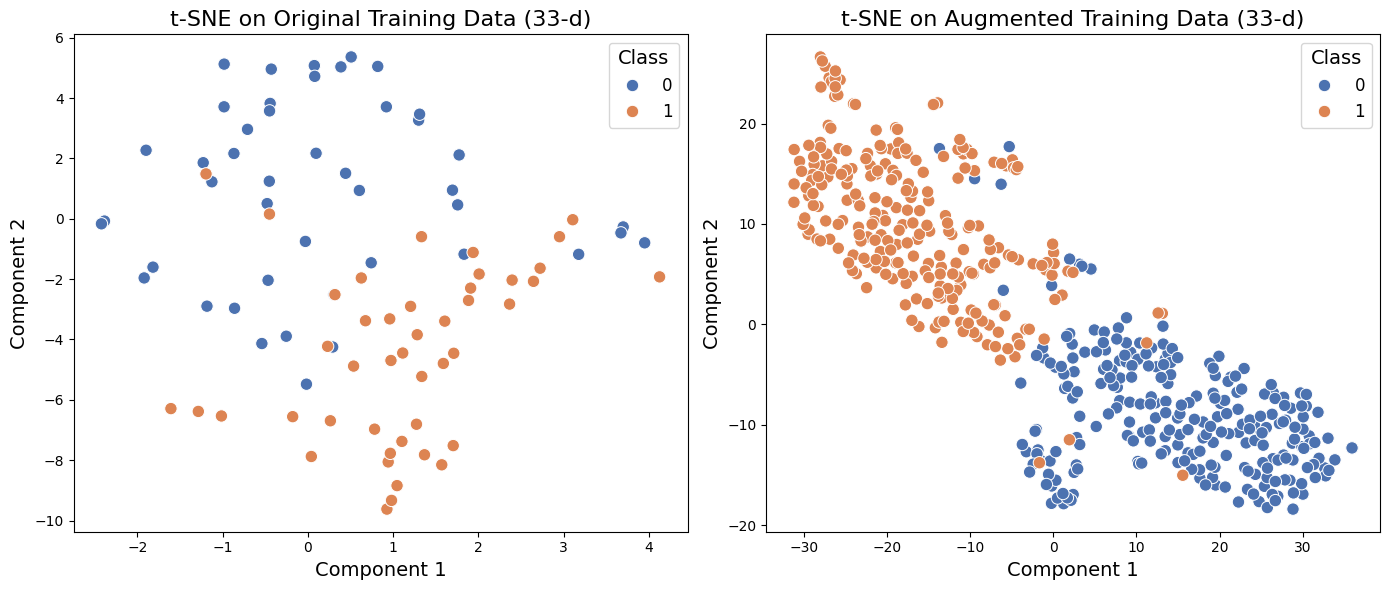

In [13]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne_original = tsne.fit_transform(X_train_final)
X_tsne_aug = tsne.fit_transform(X_train_aug)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tsne_original[:, 0], y=X_tsne_original[:, 1],
                hue=y_train.astype(int), palette="deep", s=80)
plt.title("t-SNE on Original Training Data (33-d)", fontsize=16)
plt.xlabel("Component 1", fontsize=14)
plt.ylabel("Component 2", fontsize=14)
plt.legend(title="Class", fontsize=12, title_fontsize=14)

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne_aug[:, 0], y=X_tsne_aug[:, 1],
                hue=y_train_aug.astype(int), palette="deep", s=80)
plt.title("t-SNE on Augmented Training Data (33-d)", fontsize=16)
plt.xlabel("Component 1", fontsize=14)
plt.ylabel("Component 2", fontsize=14)
plt.legend(title="Class", fontsize=12, title_fontsize=14)

plt.tight_layout()
# plt.savefig("tsne_comparison.png", dpi=300)
plt.show()


[Original Training] Independent Test Accuracy = 82.05%
New best parameters (GridSearch on augmented training set): {'C': 1000, 'kernel': 'linear'}

[Augmented Training with new GridSearch] Independent Test Accuracy = 79.49%


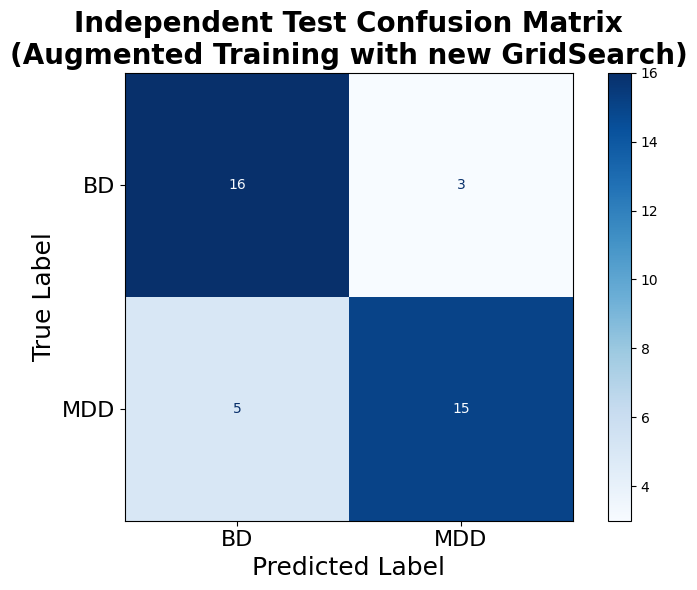

In [14]:
clf_original = SVC(**best_overall["best_params"])
clf_original.fit(X_train_final, y_train)
y_pred_test_orig = clf_original.predict(X_test_final)
test_acc_orig = accuracy_score(y_test, y_pred_test_orig)
print(f"\n[Original Training] Independent Test Accuracy = {test_acc_orig*100:.2f}%")

param_grid = [
    {'kernel': ['rbf'],
     'C': [0.1, 1, 10, 100, 1000],
     'gamma': [1.05**exp for exp in range(-100, 101, 10)]},
    {'kernel': ['linear'],
     'C': [0.1, 1, 10, 100, 1000]}
]

from sklearn.model_selection import LeaveOneOut, GridSearchCV
cv_obj = LeaveOneOut()
grid_aug = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring="accuracy", cv=cv_obj, n_jobs=-1)
grid_aug.fit(X_train_aug, y_train_aug)
new_best_params = grid_aug.best_params_
print("New best parameters (GridSearch on augmented training set):", new_best_params)

clf_aug_new = SVC(**new_best_params)
clf_aug_new.fit(X_train_aug, y_train_aug)
y_pred_test_aug_new = clf_aug_new.predict(X_test_final)
test_acc_aug_new = accuracy_score(y_test, y_pred_test_aug_new)
print(f"\n[Augmented Training with new GridSearch] Independent Test Accuracy = {test_acc_aug_new*100:.2f}%")

cm_aug_new = confusion_matrix(y_test, y_pred_test_aug_new)
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_aug_new, display_labels=["BD", "MDD"])
fig, ax = plt.subplots(figsize=(8, 6))
disp_new.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Independent Test Confusion Matrix\n(Augmented Training with new GridSearch)", fontsize=20, fontweight="bold")
ax.set_xlabel("Predicted Label", fontsize=18)
ax.set_ylabel("True Label", fontsize=18)
ax.tick_params(axis="both", labelsize=16)
plt.tight_layout()
# plt.savefig("independent_test_confusion_matrix_aug_new.png", dpi=300)
plt.show()

##### VQ-VAE

VQ-VAE training - Class0 (BD) samples: torch.Size([45, 33])
VQ-VAE training - Class1 (MDD) samples: torch.Size([45, 33])

Training VQ-VAE for class 0 (BD) with PyTorch ...
Epoch [10/100], Loss: 0.1587
Epoch [20/100], Loss: 0.1524
Epoch [30/100], Loss: 0.1495
Epoch [40/100], Loss: 0.1495
Epoch [50/100], Loss: 0.1025
Epoch [60/100], Loss: 0.0973
Epoch [70/100], Loss: 0.0883
Epoch [80/100], Loss: 0.0859
Epoch [90/100], Loss: 0.0795
Epoch [100/100], Loss: 0.0766

Training VQ-VAE for class 1 (MDD) with PyTorch ...
Epoch [10/100], Loss: 0.1642
Epoch [20/100], Loss: 0.1079
Epoch [30/100], Loss: 0.1039
Epoch [40/100], Loss: 0.1028
Epoch [50/100], Loss: 0.1013
Epoch [60/100], Loss: 0.1059
Epoch [70/100], Loss: 0.0983
Epoch [80/100], Loss: 0.0907
Epoch [90/100], Loss: 0.0587
Epoch [100/100], Loss: 0.0516
Synthetic samples (PyTorch, VQ-VAE) for class 0: (200, 33)
Synthetic samples (PyTorch, VQ-VAE) for class 1: (200, 33)
Augmented training set shape: (490, 33) (490,)


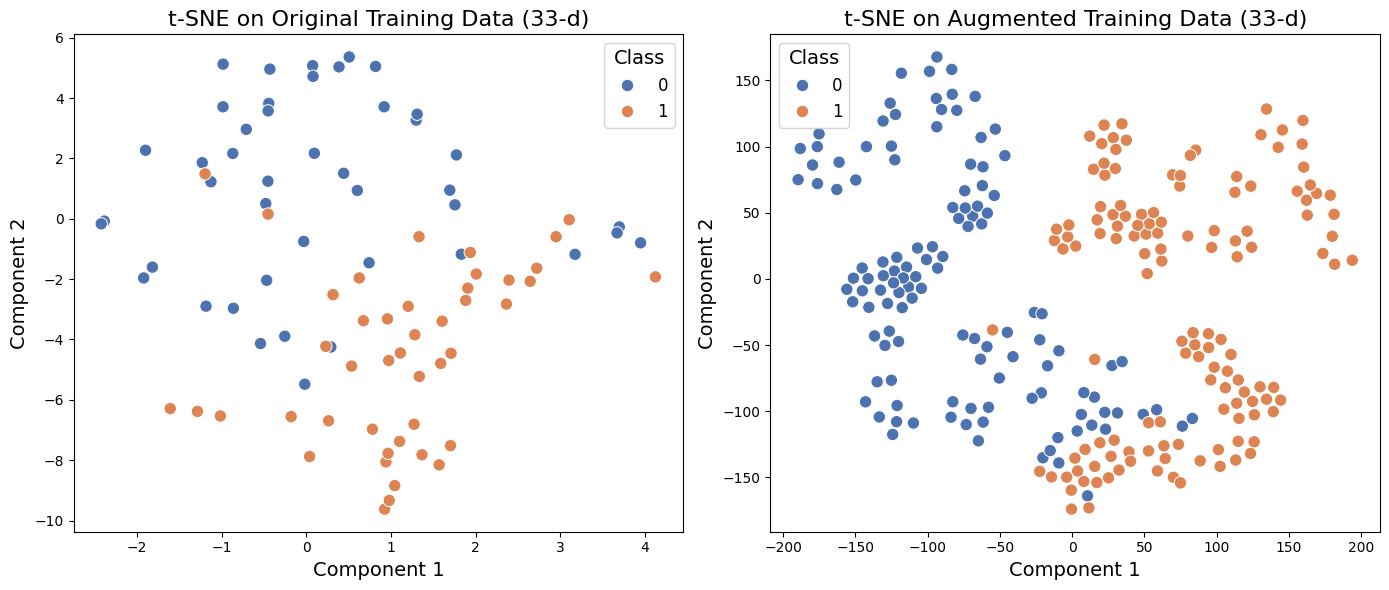


[Original Training] Independent Test Accuracy = 82.05%
New best parameters (GridSearch on augmented training set): {'C': 1000, 'gamma': 0.14204568230027764, 'kernel': 'rbf'}

[Augmented Training with new GridSearch] Independent Test Accuracy = 82.05%


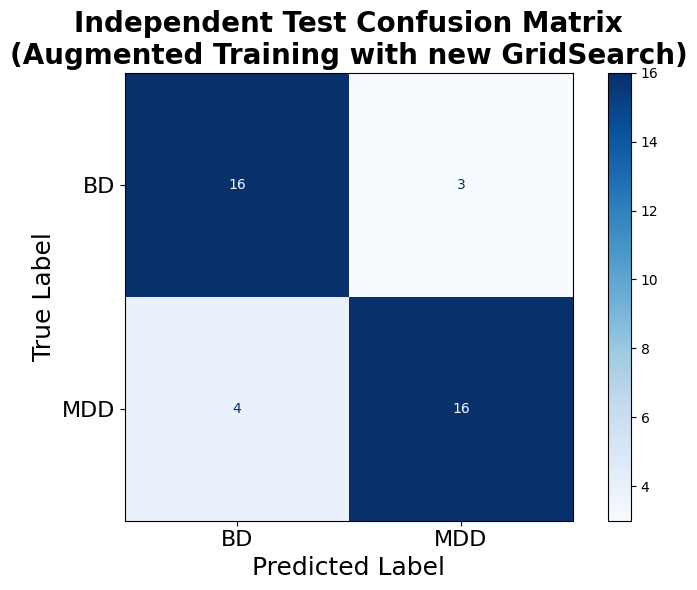

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. 實作向量量化層
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        """
        num_embeddings: codebook size
        embedding_dim:  code dim（same as encoder output）
        commitment_cost: commitment loss
        """
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1.0/num_embeddings, 1.0/num_embeddings)
        
    def forward(self, z):
        # z shape: (batch, latent_dim)
        z_flat = z.view(-1, self.embedding_dim)  # (B, D)
        
        # 計算 z 與 codebook 中各向量的歐式距離 (利用平方展開公式)
        distances = torch.sum(z_flat**2, dim=1, keepdim=True) + \
                    torch.sum(self.embeddings.weight**2, dim=1) - \
                    2 * torch.matmul(z_flat, self.embeddings.weight.t())
        
        # 找出最近的 codebook 向量
        encoding_indices = torch.argmin(distances, dim=1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=z.device)
        encodings.scatter_(1, encoding_indices.unsqueeze(1), 1)
        
        # 取得量化後的向量
        quantized = torch.matmul(encodings, self.embeddings.weight)
        quantized = quantized.view(z.shape)
        
        # 計算損失（codebook 與 commitment 損失）
        loss = torch.mean((quantized.detach() - z)**2) + \
               self.commitment_cost * torch.mean((quantized - z.detach())**2)
        
        # 透過 straight-through estimator 進行反向傳播
        quantized = z + (quantized - z).detach()
        return quantized, loss

# 2. 修改 VAE 架構成 VQ-VAE 模型
class ComplexVQVAE(nn.Module):
    def __init__(self, input_dim=33, latent_dim=10, num_embeddings=64, commitment_cost=0.25):
        """
        input_dim: 輸入特徵數 (例如 33)
        latent_dim: 潛在向量維度
        num_embeddings: codebook 中 code 的數量
        commitment_cost: commitment 損失係數
        """
        super(ComplexVQVAE, self).__init__()
        self.input_dim = input_dim
        
        # Encoder 部分：先重塑後經由 1D convolution，再進入全連接層提取特徵
        self.conv1d_enc = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc_enc = nn.Sequential(
            nn.Linear(16 * input_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 產生連續潛在向量 (encoder 的輸出)
        self.fc_quant = nn.Linear(32, latent_dim)
        
        # 向量量化層
        self.vq_layer = VectorQuantizer(num_embeddings=num_embeddings, 
                                        embedding_dim=latent_dim, 
                                        commitment_cost=commitment_cost)
        
        # Decoder 部分：由全連接層映射，再重塑後經由 1D convolution 重建原始輸入
        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc_dec_final = nn.Linear(128, 16 * input_dim)
        self.conv1d_dec = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
    
    def encode(self, x):
        # x 原始 shape: (batch, input_dim)
        x = x.unsqueeze(1)  # (batch, 1, input_dim)
        x = self.conv1d_enc(x)  # (batch, 16, input_dim)
        x = x.view(x.size(0), -1)  # Flatten 成 (batch, 16*input_dim)
        h = self.fc_enc(x)  # (batch, 32)
        z_e = self.fc_quant(h)  # (batch, latent_dim)
        return z_e
    
    def quantize(self, z_e):
        # 利用向量量化層得到離散化的潛在向量以及量化損失
        z_q, vq_loss = self.vq_layer(z_e)
        return z_q, vq_loss
    
    def decode(self, z_q):
        h = self.fc_dec(z_q)
        h = self.fc_dec_final(h)  # (batch, 16*input_dim)
        h = h.view(-1, 16, self.input_dim)  # reshape 成 (batch, 16, input_dim)
        x_recon = self.conv1d_dec(h)  # (batch, 1, input_dim)
        x_recon = x_recon.squeeze(1)  # 變回 (batch, input_dim)
        return x_recon
    
    def forward(self, x):
        z_e = self.encode(x)
        z_q, vq_loss = self.quantize(z_e)
        x_recon = self.decode(z_q)
        return x_recon, vq_loss

# VQ-VAE 的損失函數：重構損失加上向量量化損失
def vqvae_loss_function(recon_x, x, vq_loss, input_dim):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction="mean") * input_dim
    loss = recon_loss + vq_loss
    return loss

def train_vqvae(model, dataloader, epochs=100, lr=1e-3, input_dim=33):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch_x = batch[0]
            optimizer.zero_grad()
            recon_x, vq_loss = model(batch_x)
            loss = vqvae_loss_function(recon_x, batch_x, vq_loss, input_dim)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_x.size(0)
        avg_loss = total_loss / len(dataloader.dataset)
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    return model

# 由於 VQ-VAE 的 decoder 只見到量化後的 codebook 向量，
# 因此產生新樣本時可隨機抽取 codebook 中的向量作為 decoder 輸入
def generate_samples_pt(model, n_samples):
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        random_indices = torch.randint(0, model.vq_layer.num_embeddings, (n_samples,), device=device)
        z_q = model.vq_layer.embeddings(random_indices)
        x_recon = model.decode(z_q)
    return x_recon.cpu().numpy()

def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

# -------------------- 資料準備與 VQ-VAE 訓練 --------------------
# 將 SFS 後的訓練資料轉換為 PyTorch tensor 格式 (資料維度為 33)
X_train_final_tensor = to_tensor(X_train_final)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# 分別取得 BD 與 MDD 的訓練資料
X_train_class0 = X_train_final_tensor[y_train_tensor == 0]  # BD
X_train_class1 = X_train_final_tensor[y_train_tensor == 1]  # MDD
print("VQ-VAE training - Class0 (BD) samples:", X_train_class0.shape)
print("VQ-VAE training - Class1 (MDD) samples:", X_train_class1.shape)

batch_size_pt = 16
loader_class0 = DataLoader(TensorDataset(X_train_class0), batch_size=batch_size_pt, shuffle=True)
loader_class1 = DataLoader(TensorDataset(X_train_class1), batch_size=batch_size_pt, shuffle=True)

input_dim_pt = 33
latent_dim_pt = 10
epochs_pt = 100 
num_embeddings = 32
commitment_cost = 0.25

print("\nTraining VQ-VAE for class 0 (BD) with PyTorch ...")
vqvae_bd = ComplexVQVAE(input_dim=input_dim_pt, latent_dim=latent_dim_pt, 
                        num_embeddings=num_embeddings, commitment_cost=commitment_cost)
vqvae_bd = train_vqvae(vqvae_bd, loader_class0, epochs=epochs_pt, lr=1e-3, input_dim=input_dim_pt)

print("\nTraining VQ-VAE for class 1 (MDD) with PyTorch ...")
vqvae_mdd = ComplexVQVAE(input_dim=input_dim_pt, latent_dim=latent_dim_pt, 
                         num_embeddings=num_embeddings, commitment_cost=commitment_cost)
vqvae_mdd = train_vqvae(vqvae_mdd, loader_class1, epochs=epochs_pt, lr=1e-3, input_dim=input_dim_pt)

# 產生新樣本函式 (對每個類別固定產生 n_samples 筆合成資料)
n_generate = 200
synthetic_class0_pt = generate_samples_pt(vqvae_bd, n_generate)
synthetic_class1_pt = generate_samples_pt(vqvae_mdd, n_generate)
print("Synthetic samples (PyTorch, VQ-VAE) for class 0:", synthetic_class0_pt.shape)
print("Synthetic samples (PyTorch, VQ-VAE) for class 1:", synthetic_class1_pt.shape)

# 合併增強後的資料：原始 X_train_final (90 筆) + 產生的 200 筆合成資料
X_train_aug = np.concatenate([X_train_final, synthetic_class0_pt, synthetic_class1_pt], axis=0)
y_train_aug = np.concatenate([y_train, np.zeros(n_generate), np.ones(n_generate)], axis=0)
print("Augmented training set shape:", X_train_aug.shape, y_train_aug.shape)

# -------------------- t-SNE 資料視覺化 --------------------
tsne = TSNE(n_components=2, random_state=42)
X_tsne_original = tsne.fit_transform(X_train_final)
X_tsne_aug = tsne.fit_transform(X_train_aug)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.scatterplot(x=X_tsne_original[:,0], y=X_tsne_original[:,1], 
                hue=y_train.astype(int), palette="deep", s=80)
plt.title("t-SNE on Original Training Data (33-d)", fontsize=16)
plt.xlabel("Component 1", fontsize=14)
plt.ylabel("Component 2", fontsize=14)
plt.legend(title="Class", fontsize=12, title_fontsize=14)

plt.subplot(1,2,2)
sns.scatterplot(x=X_tsne_aug[:,0], y=X_tsne_aug[:,1], 
                hue=y_train_aug.astype(int), palette="deep", s=80)
plt.title("t-SNE on Augmented Training Data (33-d)", fontsize=16)
plt.xlabel("Component 1", fontsize=14)
plt.ylabel("Component 2", fontsize=14)
plt.legend(title="Class", fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.savefig("tsne_comparison.png", dpi=300)
plt.show()

# -------------------- SVC 分類器訓練與評估 --------------------
from sklearn.model_selection import LeaveOneOut, GridSearchCV

# 使用最佳 SFS 所選參數建立原始 SVC 模型
clf_original = SVC(**best_overall["best_params"])
clf_original.fit(X_train_final, y_train)
y_pred_test_orig = clf_original.predict(X_test_final)
test_acc_orig = accuracy_score(y_test, y_pred_test_orig)
print(f"\n[Original Training] Independent Test Accuracy = {test_acc_orig*100:.2f}%")

param_grid = [
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1.05**exp for exp in range(-100, 101, 10)]
    },
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100, 1000]
    }
]

# 使用 LOOCV 進行 GridSearchCV，以增強後的資料尋找最佳參數
cv_obj = LeaveOneOut()
grid_aug = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring="accuracy", cv=cv_obj, n_jobs=-1)
grid_aug.fit(X_train_aug, y_train_aug)

new_best_params = grid_aug.best_params_
print("New best parameters (GridSearch on augmented training set):", new_best_params)

# 使用新的最佳參數訓練 SVC 分類器 (基於增強後資料)
clf_aug_new = SVC(**new_best_params)
clf_aug_new.fit(X_train_aug, y_train_aug)
y_pred_test_aug_new = clf_aug_new.predict(X_test_final)
test_acc_aug_new = accuracy_score(y_test, y_pred_test_aug_new)
print(f"\n[Augmented Training with new GridSearch] Independent Test Accuracy = {test_acc_aug_new*100:.2f}%")

# 繪製新的獨立測試集 Confusion Matrix
cm_aug_new = confusion_matrix(y_test, y_pred_test_aug_new)
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_aug_new, display_labels=["BD", "MDD"])
fig, ax = plt.subplots(figsize=(8, 6))
disp_new.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Independent Test Confusion Matrix\n(Augmented Training with new GridSearch)", fontsize=20, fontweight="bold")
ax.set_xlabel("Predicted Label", fontsize=18)
ax.set_ylabel("True Label", fontsize=18)
ax.tick_params(axis="both", labelsize=16)
plt.tight_layout()
plt.savefig("independent_test_confusion_matrix_aug_new.png", dpi=300)
plt.show()

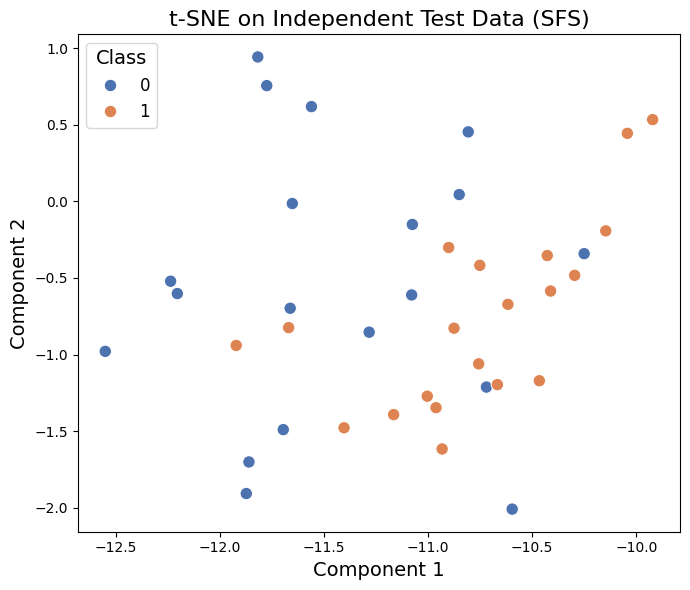

##### cVAE


Training merged cVAE model with PyTorch ...


Epochs: 100%|██████████| 150/150 [00:20<00:00,  7.45it/s, loss=0.1341]


Synthetic samples (PyTorch, merged cVAE) for class 0: (200, 33)
Synthetic samples (PyTorch, merged cVAE) for class 1: (200, 33)
Augmented training set shape: (490, 33) (490,)


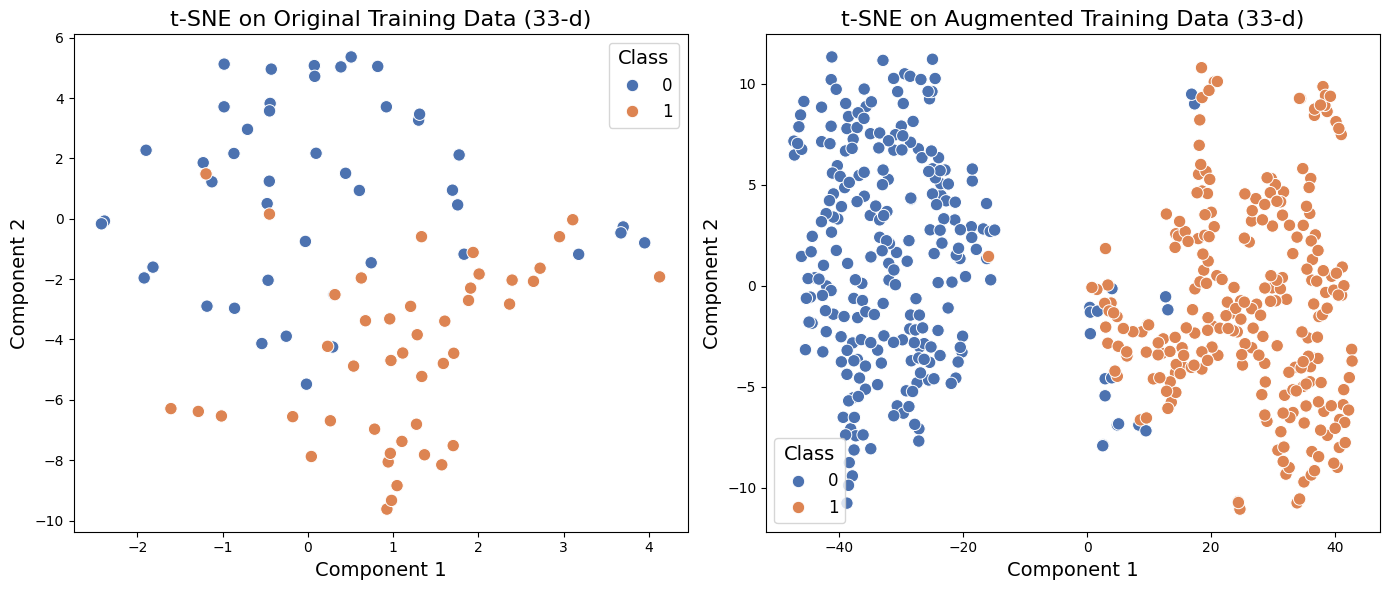


[Original Training] Independent Test Accuracy = 82.05%
New best parameters (GridSearch on augmented training set): {'C': 1000, 'gamma': 0.6139132535407591, 'kernel': 'rbf'}

[Augmented Training with new GridSearch] Independent Test Accuracy = 76.92%


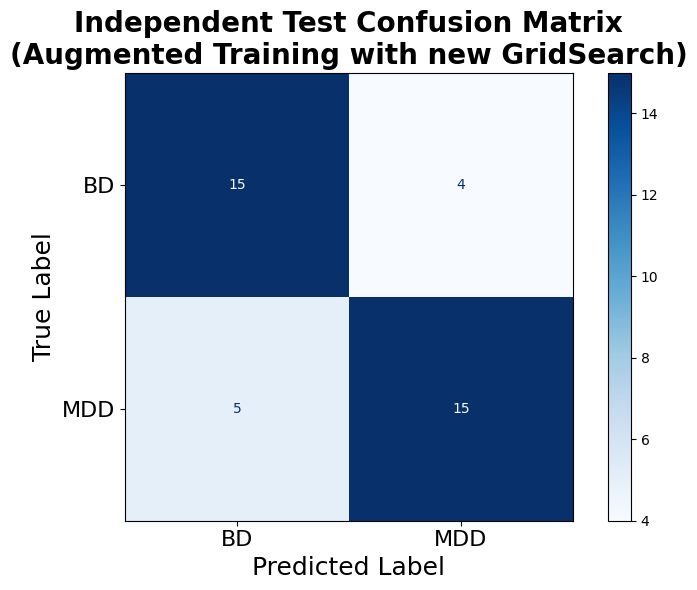

In [109]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# =============================================================================
# 1. cVAE 模型定義
# =============================================================================

class ComplexcVAE(nn.Module):
    def __init__(self, input_dim=33, latent_dim=10, num_classes=2):
        """
        input_dim: 資料每個樣本的維度 (例如33)
        latent_dim: 潛在空間維度
        num_classes: 條件資訊的維度 (例如2)
        """
        super(ComplexcVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # --- Encoder ---
        # (1) 1D 卷積層：輸入 shape: (B, 1, input_dim)
        # 通過3層卷積，將單通道轉換為 64 個通道，並保留原始序列長度（padding=1）
        self.conv1d_enc = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # (2) Flatten 並與條件資訊串接：展平成 (B, 64*input_dim)，再 concat one-hot 條件 (B, num_classes)
        self.fc_enc = nn.Sequential(
            nn.Linear(64 * input_dim + num_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # (3) 產生潛在分布參數：分別輸出均值(mu)與對數變異數(logvar)
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
        
        # --- Decoder ---
        # (1) 將潛在向量與條件資訊串接，輸入形狀: (B, latent_dim + num_classes)
        # 全連接層：逐步將串接後的向量映射到一個中間表示 (B, 256)
        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # (2) 從中間表示映射到 64 * input_dim，並 reshape 成 (B, 64, input_dim)
        self.fc_dec_final = nn.Linear(256, 64 * input_dim)
        # (3) 利用多層 1D 卷積還原通道數：64 → 32 → 16 → 8 → 1
        self.conv1d_dec = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=8, out_channels=1, kernel_size=3, padding=1)
        )
    
    def encode(self, x, c):
        """
        Encoder: 將輸入 x 與條件 c 結合後映射到潛在分布參數
         - x: 輸入向量，形狀 (B, input_dim)
         - c: 條件資訊 (one-hot)，形狀 (B, num_classes)
        """
        x = x.unsqueeze(1)                  # 變為 (B, 1, input_dim)
        x = self.conv1d_enc(x)              # (B, 64, input_dim)
        x = x.view(x.size(0), -1)           # Flatten => (B, 64 * input_dim)
        x = torch.cat([x, c], dim=1)         # 串接條件 => (B, 64*input_dim + num_classes)
        h = self.fc_enc(x)                 # (B, 32)
        mu = self.fc_mu(h)                 # 均值, (B, latent_dim)
        logvar = self.fc_logvar(h)         # 對數變異數, (B, latent_dim)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """
        重參數化技巧: 透過 mu, logvar 生成可微分的隨機潛在向量 z
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        """
        Decoder: 透過潛在向量與條件資訊生成重構輸出
         - z: 潛在向量 (B, latent_dim)
         - c: 條件資訊 (B, num_classes)
        """
        z_cond = torch.cat([z, c], dim=1)    # (B, latent_dim + num_classes)
        h = self.fc_dec(z_cond)              # (B, 256) (經 fc_dec 的映射)
        h = self.fc_dec_final(h)             # (B, 64 * input_dim)
        h = h.view(-1, 64, self.input_dim)     # reshape => (B, 64, input_dim)
        x_recon = self.conv1d_dec(h)         # (B, 1, input_dim)
        x_recon = x_recon.squeeze(1)         # (B, input_dim)
        return x_recon
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar

# =============================================================================
# 2. 損失函數
# =============================================================================

def loss_function(recon_x, x, mu, logvar, input_dim, beta=1.0):
    """
    損失函數 = 重構誤差 (MSE) + beta * KL 散度
    - MSE: 衡量重構 x 與原始 x 之間的平均平方誤差並乘以 input_dim 以校正尺度。
    - KL: 使潛在分布接近標準正態分布。
    """
    MSE = nn.functional.mse_loss(recon_x, x, reduction="mean") * input_dim
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD

# =============================================================================
# 3. 訓練函式（合併訓練）
# =============================================================================

def train_cvae(model, dataloader, epochs=100, lr=1e-3, input_dim=33, beta=1.0):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    pbar = tqdm(range(epochs), desc="Epochs", leave=True)
    for epoch in pbar:
        total_loss = 0
        for batch in dataloader:
            batch_x = batch[0]  # (B, input_dim)
            batch_c = batch[1]  # (B, num_classes)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(batch_x, batch_c)
            loss = loss_function(recon_x, batch_x, mu, logvar, input_dim, beta)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_x.size(0)
        avg_loss = total_loss / len(dataloader.dataset)
        pbar.set_postfix(loss=f"{avg_loss:.4f}")
    return model

# =============================================================================
# 4. 產生合成資料函式
# =============================================================================

def generate_samples_pt(model, n_samples, latent_dim, c):
    """
    從潛在空間採樣並根據條件資訊 c 生成新樣本
      - c: 條件資訊，形狀應為 (n_samples, num_classes)
    """
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim)
        generated = model.decode(z, c)
    return generated.cpu().numpy()

def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)


# =============================================================================
# 5. 數據準備（合併訓練）
# =============================================================================

# 這裡假設你已有預處理後的資料：
# X_train_final: shape (num_train, 33)
# y_train: shape (num_train,)，標籤為 0 或 1
# 注意：請確認 X_train_final 與 y_train 已正確定義

# 將資料轉換成 Tensor
X_train_final_tensor = to_tensor(X_train_final)  # (num_train, 33)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # (num_train,)

# 創建條件資訊（one-hot）
def get_condition_tensor(labels, num_classes=2):
    return nn.functional.one_hot(labels, num_classes=num_classes).float()

cond_train = get_condition_tensor(y_train_tensor, num_classes=2)  # (num_train, 2)

# 建立合併訓練的 DataLoader
merged_dataset = TensorDataset(X_train_final_tensor, cond_train)
merged_loader = DataLoader(merged_dataset, batch_size=16, shuffle=True)

# =============================================================================
# 6. 訓練合併的 cVAE 模型
# =============================================================================

input_dim_pt = 33
latent_dim_pt = 15  # 可以根據需求調整
num_classes = 2
epochs_pt = 150

print("\nTraining merged cVAE model with PyTorch ...")
cvae_merged = ComplexcVAE(input_dim=input_dim_pt, latent_dim=latent_dim_pt, num_classes=num_classes)
cvae_merged = train_cvae(cvae_merged, merged_loader, epochs=epochs_pt, lr=1e-3, input_dim=input_dim_pt, beta=1.0)

# =============================================================================
# 7. 合成資料生成與增強數據製作
# =============================================================================

n_generate = 200

# 生成 class 0 的合成資料：條件向量 [1, 0]
cond_gen_class0 = torch.zeros(n_generate, num_classes)
cond_gen_class0[:, 0] = 1.0
synthetic_class0_pt = generate_samples_pt(cvae_merged, n_samples=n_generate, latent_dim=latent_dim_pt, c=cond_gen_class0)

# 生成 class 1 的合成資料：條件向量 [0, 1]
cond_gen_class1 = torch.zeros(n_generate, num_classes)
cond_gen_class1[:, 1] = 1.0
synthetic_class1_pt = generate_samples_pt(cvae_merged, n_samples=n_generate, latent_dim=latent_dim_pt, c=cond_gen_class1)

print("Synthetic samples (PyTorch, merged cVAE) for class 0:", synthetic_class0_pt.shape)
print("Synthetic samples (PyTorch, merged cVAE) for class 1:", synthetic_class1_pt.shape)

# 合併原始資料與合成資料
X_train_aug = np.concatenate([X_train_final, synthetic_class0_pt, synthetic_class1_pt], axis=0)
y_train_aug = np.concatenate([y_train, np.zeros(n_generate), np.ones(n_generate)], axis=0)
print("Augmented training set shape:", X_train_aug.shape, y_train_aug.shape)

# =============================================================================
# 8. t-SNE 資料視覺化
# =============================================================================

tsne = TSNE(n_components=2, random_state=42)
X_tsne_original = tsne.fit_transform(X_train_final)
X_tsne_aug = tsne.fit_transform(X_train_aug)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tsne_original[:, 0], y=X_tsne_original[:, 1],
                hue=y_train.astype(int), palette="deep", s=80)
plt.title("t-SNE on Original Training Data (33-d)", fontsize=16)
plt.xlabel("Component 1", fontsize=14)
plt.ylabel("Component 2", fontsize=14)
plt.legend(title="Class", fontsize=12, title_fontsize=14)

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne_aug[:, 0], y=X_tsne_aug[:, 1],
                hue=y_train_aug.astype(int), palette="deep", s=80)
plt.title("t-SNE on Augmented Training Data (33-d)", fontsize=16)
plt.xlabel("Component 1", fontsize=14)
plt.ylabel("Component 2", fontsize=14)
plt.legend(title="Class", fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.savefig("tsne_comparison.png", dpi=300)
plt.show()

# =============================================================================
# 9. SVC 分類器訓練與獨立測試評估
# =============================================================================

# 假設 X_test_final 與 y_test 已正確定義
# X_test_final: (num_test, 33)
# y_test: (num_test,)

# 使用先前透過特徵選取 (SFS) 得到的最佳參數 best_overall["best_params"]
clf_original = SVC(**best_overall["best_params"])
clf_original.fit(X_train_final, y_train)
y_pred_test_orig = clf_original.predict(X_test_final)
test_acc_orig = accuracy_score(y_test, y_pred_test_orig)
print(f"\n[Original Training] Independent Test Accuracy = {test_acc_orig*100:.2f}%")

param_grid = [
    {'kernel': ['rbf'],
     'C': [0.1, 1, 10, 100, 1000],
     'gamma': [1.05**exp for exp in range(-100, 101, 10)]},
    {'kernel': ['linear'],
     'C': [0.1, 1, 10, 100, 1000]}
]

cv_obj = LeaveOneOut()
grid_aug = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring="accuracy", cv=cv_obj, n_jobs=-1)
grid_aug.fit(X_train_aug, y_train_aug)
new_best_params = grid_aug.best_params_
print("New best parameters (GridSearch on augmented training set):", new_best_params)

clf_aug_new = SVC(**new_best_params)
clf_aug_new.fit(X_train_aug, y_train_aug)
y_pred_test_aug_new = clf_aug_new.predict(X_test_final)
test_acc_aug_new = accuracy_score(y_test, y_pred_test_aug_new)
print(f"\n[Augmented Training with new GridSearch] Independent Test Accuracy = {test_acc_aug_new*100:.2f}%")

cm_aug_new = confusion_matrix(y_test, y_pred_test_aug_new)
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_aug_new, display_labels=["BD", "MDD"])
fig, ax = plt.subplots(figsize=(8, 6))
disp_new.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Independent Test Confusion Matrix\n(Augmented Training with new GridSearch)", fontsize=20, fontweight="bold")
ax.set_xlabel("Predicted Label", fontsize=18)
ax.set_ylabel("True Label", fontsize=18)
ax.tick_params(axis="both", labelsize=16)
plt.tight_layout()
plt.savefig("independent_test_confusion_matrix_aug_new.png", dpi=300)
plt.show()

##### save result

In [15]:
import pickle


results = {

    "cvae_state_dict": cvae_merged.state_dict(),
    

    "X_train_final": X_train_final,      
    "y_train": y_train,
    "X_test_final": X_test_final,
    "y_test": y_test,
    

    "X_train_aug": X_train_aug,
    "y_train_aug": y_train_aug,
    

    "X_tsne_original": X_tsne_original,
    "X_tsne_aug": X_tsne_aug,
    

    "new_best_params": new_best_params,
    

    "clf_original": clf_original,
    "clf_aug_new": clf_aug_new
}


with open("../result/BD_MDD/info_cvae/results_test.pkl", "wb") as f:
    pickle.dump(results, f)

##### DA size analyze

In [18]:
latent_dim_pt = 15
model = cVAE(input_dim=X_train_final.shape[1], latent_dim=latent_dim_pt, num_classes=2)
with open("../result/BD_MDD/info_cvae/results_test.pkl", "rb") as f:
    results = pickle.load(f)
model.load_state_dict(results["cvae_state_dict"])
model.eval()

cVAE(
  (conv1d_enc): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_enc): Sequential(
    (0): Linear(in_features=2114, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_mu): Linear(in_features=32, out_features=15, bias=True)
  (fc_logvar): Linear(in_features=32, out_feature

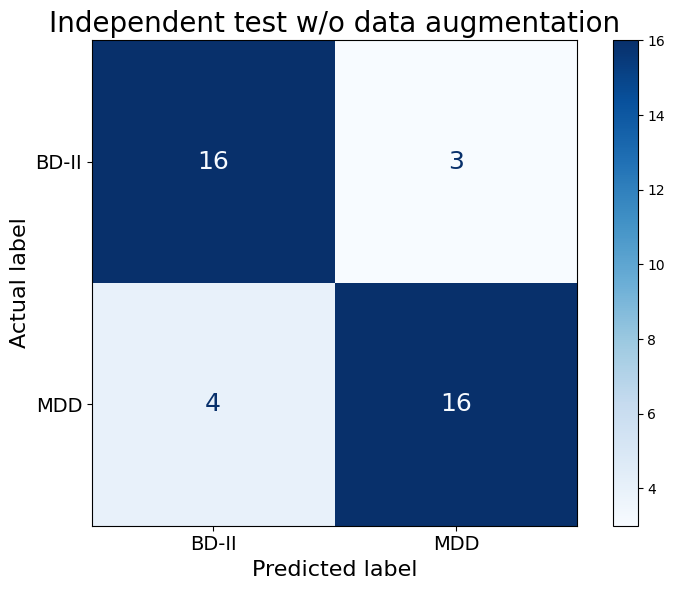

In [19]:
clf_orig = SVC(**best_overall["best_params"])
clf_orig.fit(X_train_final, y_train)
y_pred_orig = clf_orig.predict(X_test_final)
cm_orig = confusion_matrix(y_test, y_pred_orig)
fig1, ax1 = plt.subplots(figsize=(8,6))
disp1 = ConfusionMatrixDisplay(
    cm_orig,
    display_labels=["BD-II", "MDD"]
).plot(
    ax=ax1,
    cmap=plt.cm.Blues,
    text_kw={'fontsize':18}
)
ax1.set_title("Independent test w/o data augmentation", fontsize=20)
ax1.set_xlabel("Predicted label", fontsize=16)
ax1.set_ylabel("Actual label", fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/confusion_before_augmentation.png")

In [89]:
augmentation_counts = list(range(50, 501, 10))
accuracies = []
synthetic_data = {}
for r in augmentation_counts:
    cond0 = torch.zeros(r, 2); cond0[:,0] = 1
    cond1 = torch.zeros(r, 2); cond1[:,1] = 1
    synth0 = model.decode(torch.randn(r, latent_dim_pt), cond0).detach().cpu().numpy()
    synth1 = model.decode(torch.randn(r, latent_dim_pt), cond1).detach().cpu().numpy()
    synthetic_data[r] = {'class0': synth0, 'class1': synth1}

    X_aug = np.vstack([X_train_final, synth0, synth1])
    y_aug = np.concatenate([y_train, np.zeros(r), np.ones(r)])
    clf = SVC(**best_overall["best_params"])
    clf.fit(X_aug, y_aug)
    acc = accuracy_score(y_test, clf.predict(X_test_final))
    accuracies.append(acc)
    print(f"Augmentation per class = {r}: Test Accuracy = {acc*100:.2f}%")

Augmentation per class = 50: Test Accuracy = 82.05%
Augmentation per class = 60: Test Accuracy = 87.18%
Augmentation per class = 70: Test Accuracy = 84.62%
Augmentation per class = 80: Test Accuracy = 84.62%
Augmentation per class = 90: Test Accuracy = 84.62%
Augmentation per class = 100: Test Accuracy = 82.05%
Augmentation per class = 110: Test Accuracy = 84.62%
Augmentation per class = 120: Test Accuracy = 84.62%
Augmentation per class = 130: Test Accuracy = 84.62%
Augmentation per class = 140: Test Accuracy = 84.62%
Augmentation per class = 150: Test Accuracy = 84.62%
Augmentation per class = 160: Test Accuracy = 84.62%
Augmentation per class = 170: Test Accuracy = 84.62%
Augmentation per class = 180: Test Accuracy = 84.62%
Augmentation per class = 190: Test Accuracy = 84.62%
Augmentation per class = 200: Test Accuracy = 84.62%
Augmentation per class = 210: Test Accuracy = 87.18%
Augmentation per class = 220: Test Accuracy = 84.62%
Augmentation per class = 230: Test Accuracy = 84.62

In [20]:
param_grid = [
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1.05**exp for exp in range(-100, 101, 10)]
    },
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100, 1000]
    }
]
loo = LeaveOneOut()

augmentation_counts = list(range(50, 501, 10))
accuracies = []
synthetic_data = {}

for r in augmentation_counts:
    cond0 = torch.zeros(r, 2); cond0[:,0] = 1
    cond1 = torch.zeros(r, 2); cond1[:,1] = 1
    synth0 = model.decode(torch.randn(r, latent_dim_pt), cond0).detach().cpu().numpy()
    synth1 = model.decode(torch.randn(r, latent_dim_pt), cond1).detach().cpu().numpy()
    synthetic_data[r] = {'class0': synth0, 'class1': synth1}

    X_aug = np.vstack([X_train_final, synth0, synth1])
    y_aug = np.concatenate([y_train, np.zeros(r), np.ones(r)])


    grid = GridSearchCV(
        estimator=SVC(),
        param_grid=param_grid,
        cv=loo,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_aug, y_aug)
    best_params = grid.best_params_


    clf = SVC(**best_params)
    clf.fit(X_aug, y_aug)
    acc = accuracy_score(y_test, clf.predict(X_test_final))
    accuracies.append(acc)

    print(f"r = {r:3d} │ Best Params: {best_params} │ Test Accuracy = {acc*100:.2f}%")

r =  50 │ Best Params: {'C': 1000, 'gamma': 0.053535523746494146, 'kernel': 'rbf'} │ Test Accuracy = 76.92%
r =  60 │ Best Params: {'C': 1000, 'gamma': 0.053535523746494146, 'kernel': 'rbf'} │ Test Accuracy = 79.49%
r =  70 │ Best Params: {'C': 1000, 'gamma': 0.053535523746494146, 'kernel': 'rbf'} │ Test Accuracy = 82.05%
r =  80 │ Best Params: {'C': 1000, 'gamma': 0.14204568230027764, 'kernel': 'rbf'} │ Test Accuracy = 82.05%
r =  90 │ Best Params: {'C': 1000, 'gamma': 0.053535523746494146, 'kernel': 'rbf'} │ Test Accuracy = 79.49%
r = 100 │ Best Params: {'C': 100, 'gamma': 0.6139132535407591, 'kernel': 'rbf'} │ Test Accuracy = 76.92%
r = 110 │ Best Params: {'C': 1000, 'gamma': 0.03286616756321879, 'kernel': 'rbf'} │ Test Accuracy = 76.92%
r = 120 │ Best Params: {'C': 100, 'gamma': 0.6139132535407591, 'kernel': 'rbf'} │ Test Accuracy = 76.92%
r = 130 │ Best Params: {'C': 100, 'gamma': 1.0, 'kernel': 'rbf'} │ Test Accuracy = 76.92%
r = 140 │ Best Params: {'C': 100, 'gamma': 0.376889482

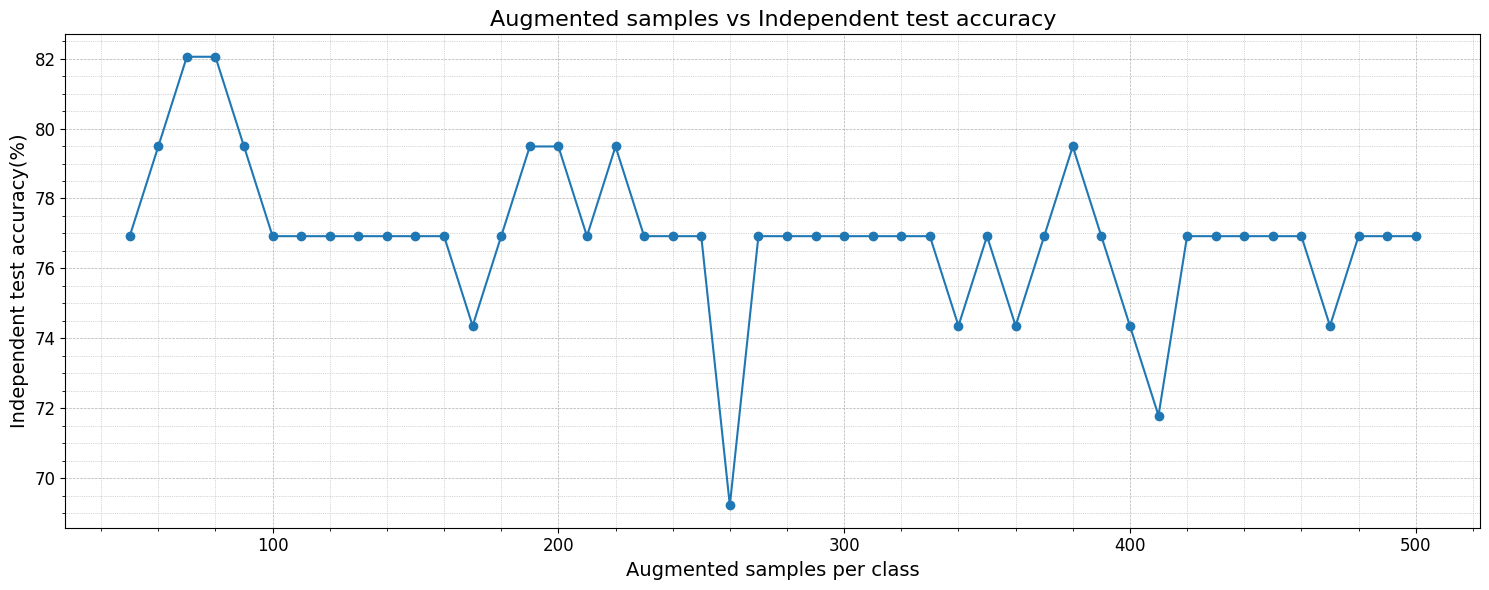

In [21]:
fig2, ax2 = plt.subplots(figsize=(15,6))
ax2.plot(augmentation_counts, [a*100 for a in accuracies], marker='o')
ax2.set_xlabel("Augmented samples per class", fontsize=14)
ax2.set_ylabel("Independent test accuracy(%)", fontsize=14)
ax2.set_title("Augmented samples vs Independent test accuracy", fontsize=16)
ax2.minorticks_on()
ax2.grid(True, which='major', linestyle='--', linewidth=0.5)
ax2.grid(True, which='minor', linestyle=':', linewidth=0.5)
ax2.tick_params(axis='both', labelsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/accuracy_vs_augmentation_num.png")

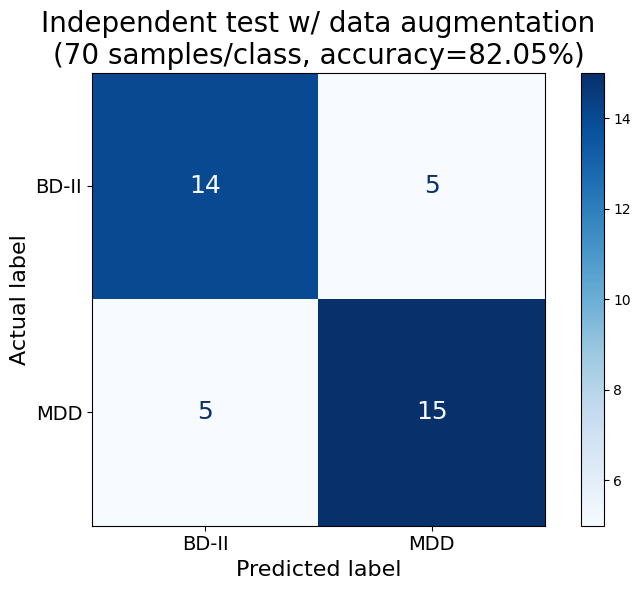

In [22]:
max_acc = max(accuracies)
best_indices = [i for i, a in enumerate(accuracies) if a == max_acc]
best_idx = best_indices[0]
r_best = augmentation_counts[best_idx]
acc_best = accuracies[best_idx] * 100

s0 = synthetic_data[r_best]['class0']
s1 = synthetic_data[r_best]['class1']
clf_best = SVC(**best_overall["best_params"])
clf_best.fit(
    np.vstack([X_train_final, s0, s1]),
    np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
)
cm_best = confusion_matrix(y_test, clf_best.predict(X_test_final))
fig3, ax3 = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay(
    cm_best,
    display_labels=["BD-II", "MDD"]
).plot(
    ax=ax3,
    cmap=plt.cm.Blues,
    text_kw={'fontsize':18}
)
ax3.set_title(
    f"Independent test w/ data augmentation\n({r_best} samples/class, accuracy={acc_best:.2f}%)",
    fontsize=20
)
ax3.set_xlabel("Predicted label", fontsize=16)
ax3.set_ylabel("Actual label", fontsize=16)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/confusion_after_augmentation.png")


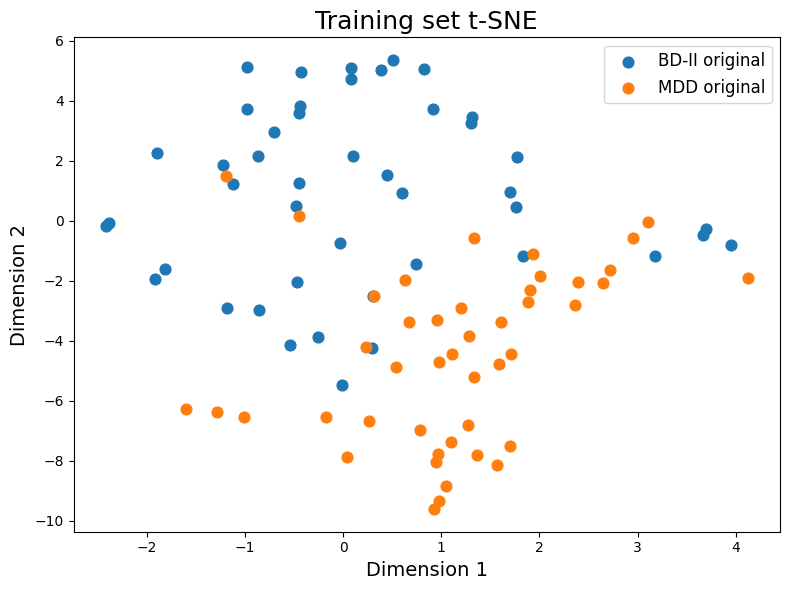

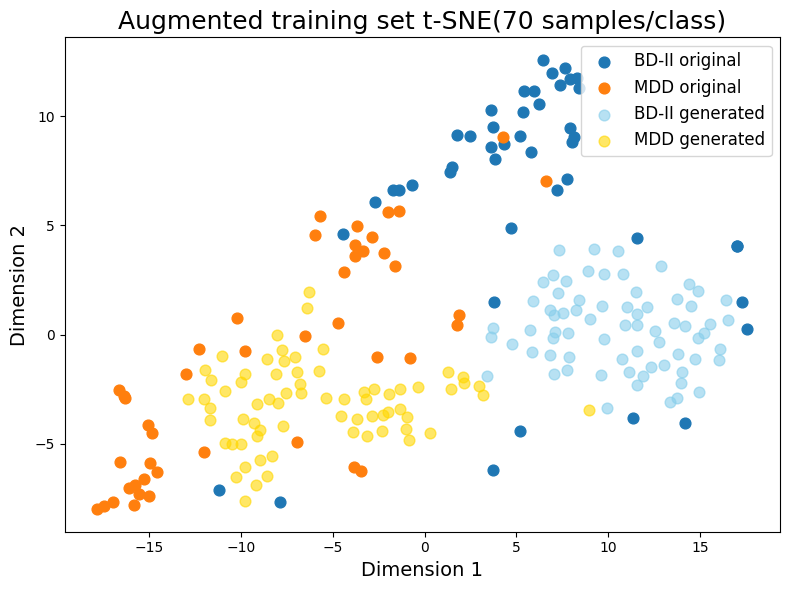

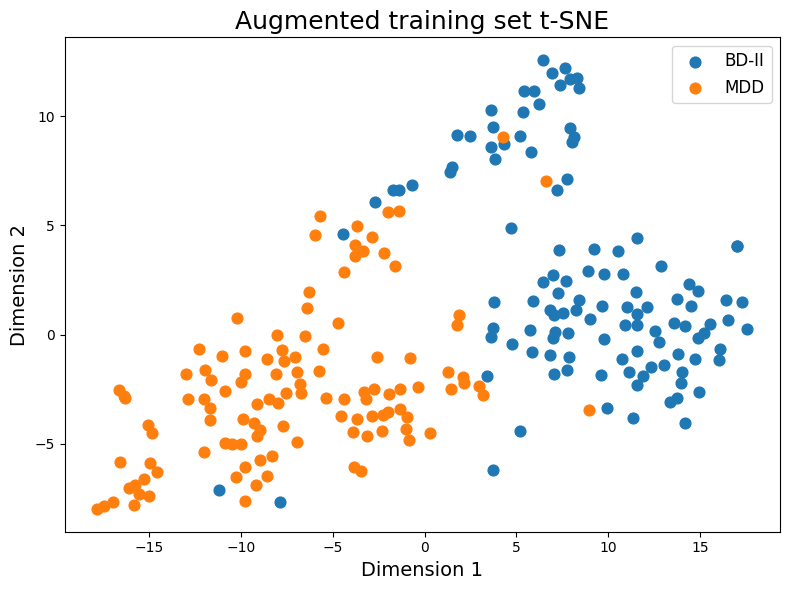

In [23]:
from sklearn.manifold import TSNE

# t-SNE before augmentation (original training set)
tsne = TSNE(n_components=2, random_state=42)
X_tsne_before = tsne.fit_transform(X_train_final)
fig_tsne1, ax_tsne1 = plt.subplots(figsize=(8,6))

colors = {'BD_orig':'tab:blue', 'BD_syn':'skyblue', 'MDD_orig':'tab:orange', 'MDD_syn':'gold'}
for label, marker, label_name, key in zip(
    [0,1], ['o','o'], ['BD-II original','MDD original'], ['BD_orig','MDD_orig']):
    idx = (y_train == label)
    ax_tsne1.scatter(
        X_tsne_before[idx,0], X_tsne_before[idx,1],
        label=label_name, marker=marker, s=60, color=colors[key]
    )
ax_tsne1.set_title("Training set t-SNE", fontsize=18)
ax_tsne1.set_xlabel("Dimension 1", fontsize=14)
ax_tsne1.set_ylabel("Dimension 2", fontsize=14)
ax_tsne1.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/tsne_before_augmentation.png")




# t-SNE after augmentation (best augmentation training set)
X_aug_best = np.vstack([X_train_final, s0, s1])
y_aug_best = np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
X_tsne_after = tsne.fit_transform(X_aug_best)
fig_tsne2, ax_tsne2 = plt.subplots(figsize=(8,6))

N_orig = len(y_train)
for label, marker, label_name, key in zip(
    [0,1], ['o','o'], ['BD-II original','MDD original'], ['BD_orig','MDD_orig']):
    orig_idx = (y_aug_best[:N_orig] == label)
    pts = X_tsne_after[:N_orig][orig_idx]
    ax_tsne2.scatter(
        pts[:,0], pts[:,1], label=label_name, marker=marker, s=60, color=colors[key]
    )

offset = N_orig
for label, marker, label_name, key in zip(
    [0,1], ['o','o'], ['BD-II generated','MDD generated'], ['BD_syn','MDD_syn']):
    syn_idx = (y_aug_best[offset:] == label)
    pts_syn = X_tsne_after[offset:][syn_idx]
    ax_tsne2.scatter(
        pts_syn[:,0], pts_syn[:,1], label=label_name, marker=marker, s=60,
        alpha=0.6, color=colors[key]
    )
ax_tsne2.set_title(f"Augmented training set t-SNE({r_best} samples/class)", fontsize=18)
ax_tsne2.set_xlabel("Dimension 1", fontsize=14)
ax_tsne2.set_ylabel("Dimension 2", fontsize=14)
ax_tsne2.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/tsne_after_augmentation.png")


tsns = TSNE(n_components=2, random_state=42)
X_combined = np.vstack([X_train_final, s0, s1])
y_combined = np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
X_tsne_comb = tsns.fit_transform(X_combined)
fig_tsne3, ax_tsne3 = plt.subplots(figsize=(8,6))
for label, marker, label_name, color in zip(
    [0,1], ['o','o'], ['BD-II','MDD'], ['tab:blue','tab:orange']):
    idx = (y_combined == label)
    ax_tsne3.scatter(
        X_tsne_comb[idx,0], X_tsne_comb[idx,1],
        label=label_name, marker=marker, s=60, color=color
    )
ax_tsne3.set_title("Augmented training set t-SNE", fontsize=18)
ax_tsne3.set_xlabel("Dimension 1", fontsize=14)
ax_tsne3.set_ylabel("Dimension 2", fontsize=14)
ax_tsne3.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/tsne_combined_augmentation.png")

In [24]:
with open("../result/BD_MDD/DA_num/synthetic_data_test.pkl", "wb") as f:
    pickle.dump(synthetic_data, f)
with open("../result/BD_MDD/DA_num/accuracy_curve_test.pkl", "wb") as f:
    pickle.dump({'counts': augmentation_counts, 'accuracies': accuracies}, f)

print(f"Saved confusion matrix for best augmentation at {r_best} samples/class with accuracy {acc_best:.2f}%.")


Saved confusion matrix for best augmentation at 70 samples/class with accuracy 82.05%.


##### review result

In [12]:
latent_dim_pt = 15
model = cVAE(input_dim=X_train_final.shape[1], latent_dim=latent_dim_pt, num_classes=2)
with open("../result/BD_MDD/info_cvae/results.pkl", "rb") as f:
    results = pickle.load(f)
model.load_state_dict(results["cvae_state_dict"])
model.eval()

cVAE(
  (conv1d_enc): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_enc): Sequential(
    (0): Linear(in_features=2114, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_mu): Linear(in_features=32, out_features=15, bias=True)
  (fc_logvar): Linear(in_features=32, out_feature

In [13]:
with open("../result/BD_MDD/DA_num/synthetic_data.pkl", "rb") as f:
    synthetic_data = pickle.load(f)
with open("../result/BD_MDD/DA_num/accuracy_curve.pkl", "rb") as f:
    acc_dict = pickle.load(f)
augmentation_counts = acc_dict['counts']
accuracies = acc_dict['accuracies']

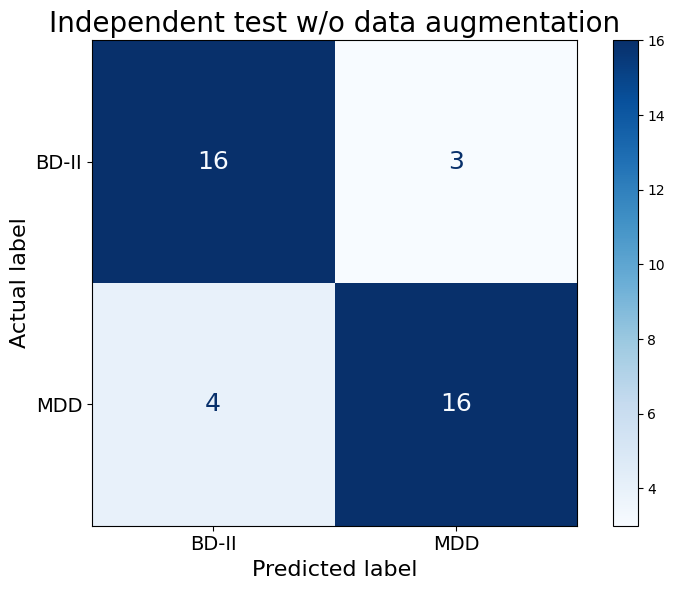

In [14]:
clf_orig = SVC(**best_overall["best_params"])
clf_orig.fit(X_train_final, y_train)
y_pred_orig = clf_orig.predict(X_test_final)
cm_orig = confusion_matrix(y_test, y_pred_orig)
fig1, ax1 = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay(
    cm_orig,
    display_labels=["BD-II", "MDD"],
).plot(
    ax=ax1, cmap=plt.cm.Blues, text_kw={'fontsize':18}
)
ax1.set_title("Independent test w/o data augmentation", fontsize=20)
ax1.set_xlabel("Predicted label", fontsize=16)
ax1.set_ylabel("Actual label", fontsize=16)
ax1.tick_params(axis='both', labelsize=14)
plt.tight_layout()
# plt.savefig("confusion_before_augmentation.png")

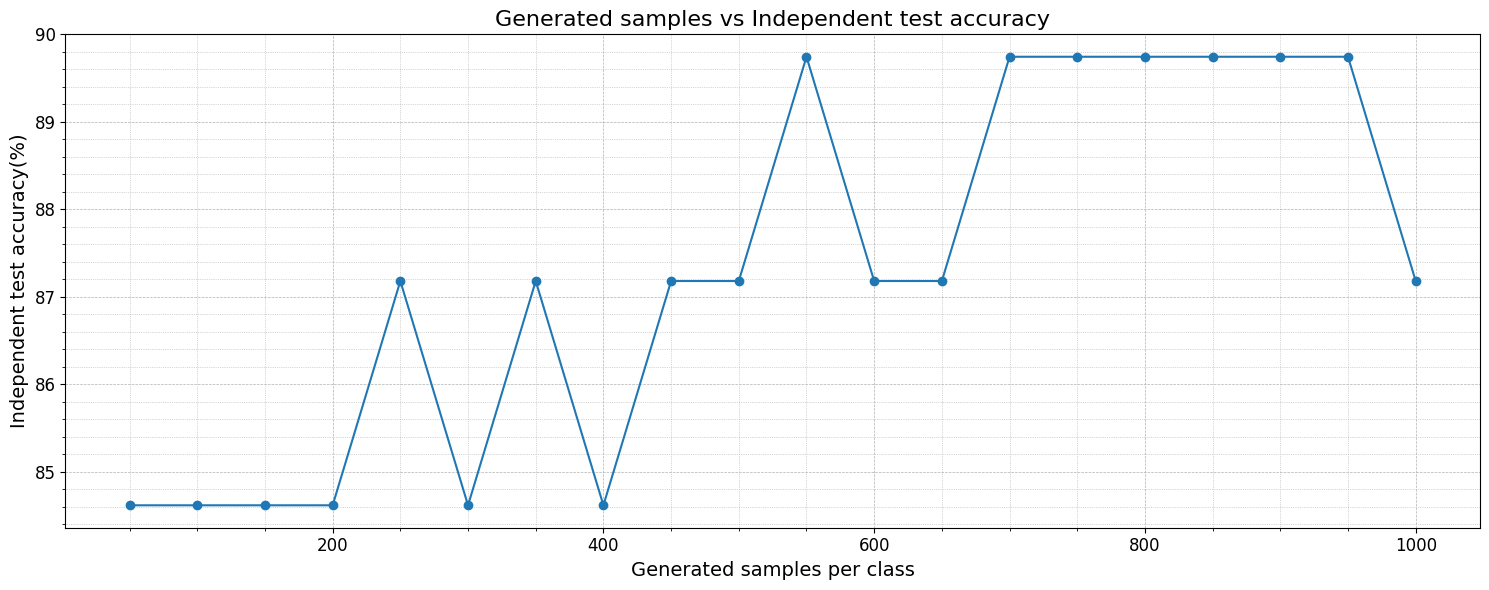

In [15]:
fig2, ax2 = plt.subplots(figsize=(15,6))
ax2.plot(augmentation_counts, [a*100 for a in accuracies], marker='o')
ax2.set_xlabel("Generated samples per class", fontsize=14)
ax2.set_ylabel("Independent test accuracy(%)", fontsize=14)
ax2.set_title("Generated samples vs Independent test accuracy", fontsize=16)
ax2.minorticks_on()
ax2.grid(True, which='major', linestyle='--', linewidth=0.5)
ax2.grid(True, which='minor', linestyle=':', linewidth=0.5)
ax2.tick_params(axis='both', labelsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/accuracy_vs_augmentation.png")

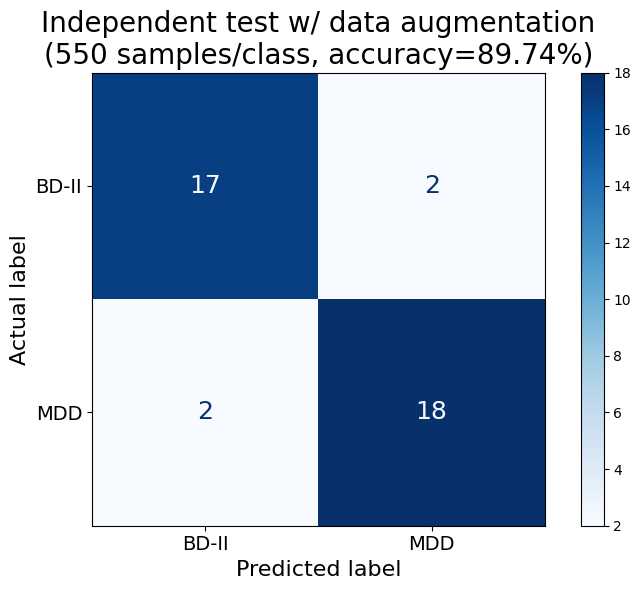

In [16]:
max_acc = max(accuracies)
best_indices = [i for i, a in enumerate(accuracies) if a == max_acc]
best_idx = best_indices[0]
r_best = augmentation_counts[best_idx]
acc_best = accuracies[best_idx] * 100

# ----- Confusion Matrix After Augmentation -----
s0 = synthetic_data[r_best]['class0']
s1 = synthetic_data[r_best]['class1']
clf_best = SVC(**best_overall["best_params"])
clf_best.fit(
    np.vstack([X_train_final, s0, s1]),
    np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
)
cm_best = confusion_matrix(y_test, clf_best.predict(X_test_final))
fig3, ax3 = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay(
    cm_best,
    display_labels=["BD-II", "MDD"],
).plot(
    ax=ax3, cmap=plt.cm.Blues, text_kw={'fontsize':18}
)
ax3.set_title(
    f"Independent test w/ data augmentation\n({r_best} samples/class, accuracy={acc_best:.2f}%)", fontsize=20
)
ax3.set_xlabel("Predicted label", fontsize=16)
ax3.set_ylabel("Actual label", fontsize=16)
ax3.tick_params(axis='both', labelsize=14)
plt.tight_layout()
# plt.savefig("confusion_after_augmentation.png")

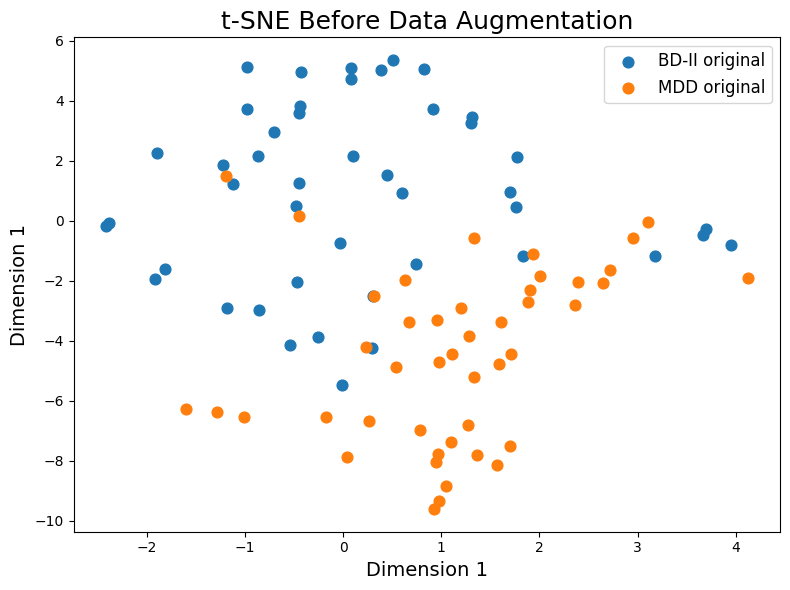

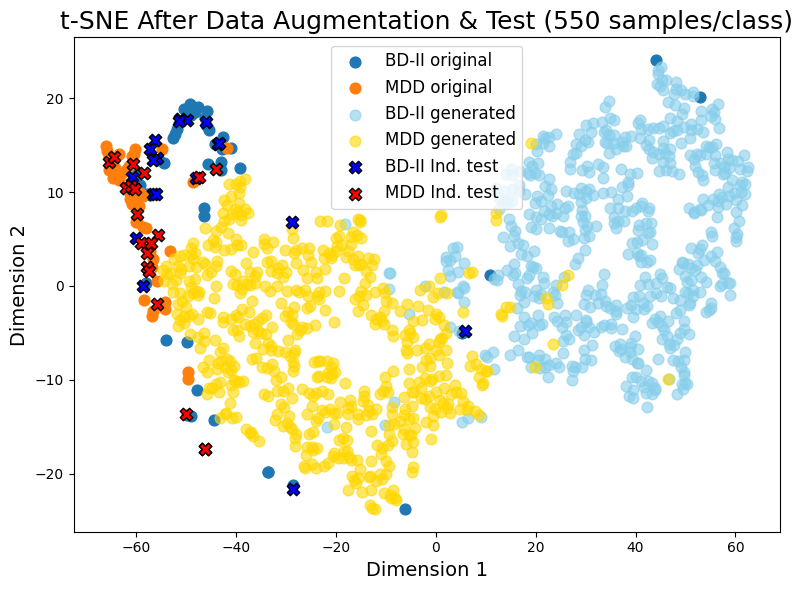

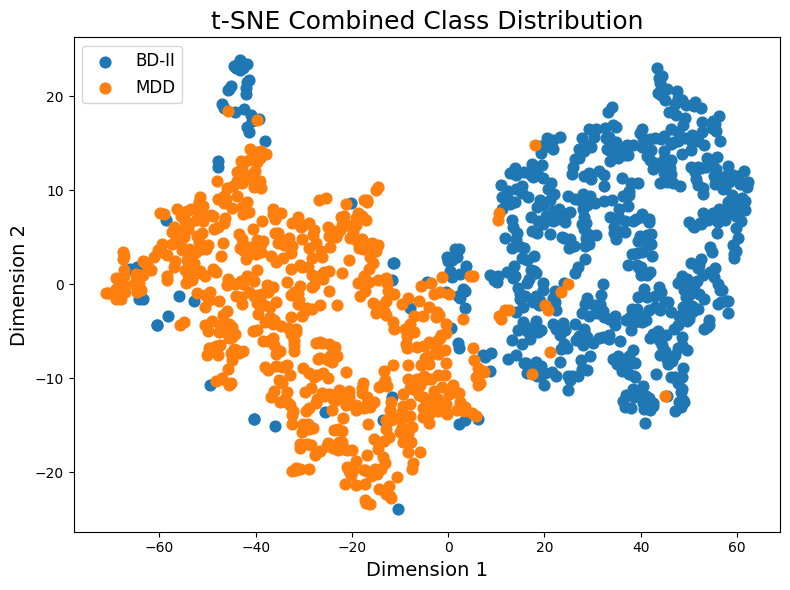

In [17]:
# ----- t-SNE Before Augmentation -----
tsne = TSNE(n_components=2, random_state=42)
X_tsne_before = tsne.fit_transform(X_train_final)
fig_tsne1, ax_tsne1 = plt.subplots(figsize=(8,6))
colors = {'BD_orig':'tab:blue', 'MDD_orig':'tab:orange'}
for label, marker, label_name, key in zip(
    [0,1], ['o','o'], ['BD-II original','MDD original'], ['BD_orig','MDD_orig']):
    idx = (y_train == label)
    ax_tsne1.scatter(X_tsne_before[idx,0], X_tsne_before[idx,1],
                     label=label_name, marker=marker, s=60, color=colors[key])
ax_tsne1.set_title("t-SNE Before Data Augmentation", fontsize=18)
ax_tsne1.set_xlabel("Dimension 1", fontsize=14)
ax_tsne1.set_ylabel("Dimension 1", fontsize=14)
ax_tsne1.legend(fontsize=12)
plt.tight_layout()

# ----- t-SNE After Augmentation -----

X_aug_best = np.vstack([X_train_final, s0, s1])
y_aug_best = np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
X_tsne_input = np.vstack([X_aug_best, X_test_final])
y_tsne_input = np.concatenate([y_aug_best, y_test])


Tsne2 = TSNE(n_components=2, random_state=42)
X_tsne2 = Tsne2.fit_transform(X_tsne_input)


fig_tsne2, ax_tsne2 = plt.subplots(figsize=(8,6))
colors_train = {'BD_orig':'tab:blue', 'BD_syn':'skyblue', 'MDD_orig':'tab:orange', 'MDD_syn':'gold'}

n_train = len(y_train)
n_syn = 2 * r_best


start, end = 0, n_train
for label, marker, key, label_name in zip([
    0, 1
], ['o','o'], ['BD_orig','MDD_orig'], ['BD-II original','MDD original']):
    idx = (y_train == label)
    pts = X_tsne2[start:end][idx]
    ax_tsne2.scatter(pts[:,0], pts[:,1], label=label_name,
                     marker=marker, s=60, color=colors_train[key])


start, end = n_train, n_train + n_syn
for label, marker, key, label_name in zip([
    0, 1
], ['o','o'], ['BD_syn','MDD_syn'], ['BD-II generated','MDD generated']):
    syn_labels = y_aug_best[start:end]
    idx = (syn_labels == label)
    pts = X_tsne2[start:end][idx]
    ax_tsne2.scatter(pts[:,0], pts[:,1], label=label_name,
                     marker=marker, s=60, color=colors_train[key], alpha=0.6)


start, end = n_train + n_syn, n_train + n_syn + len(y_test)
for label, color, label_name in zip([0,1], ['blue','red'], ['BD-II Ind. test','MDD Ind. test']):
    test_labels = y_tsne_input[start:end]
    idx = (test_labels == label)
    pts = X_tsne2[start:end][idx]
    ax_tsne2.scatter(pts[:,0], pts[:,1], label=label_name,
                     marker='X', s=80, edgecolor='k', facecolor=color)

ax_tsne2.set_title(f"t-SNE After Data Augmentation & Test ({r_best} samples/class)", fontsize=18)
ax_tsne2.set_xlabel("Dimension 1", fontsize=14)
ax_tsne2.set_ylabel("Dimension 2", fontsize=14)
ax_tsne2.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/tsne_after_with_train_test.png")



# ----- t-SNE Combined Class Distribution -----
tsns = TSNE(n_components=2, random_state=42)
X_combined = np.vstack([X_train_final, s0, s1])
y_combined = np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
X_tsne_comb = tsns.fit_transform(X_combined)
fig_tsne3, ax_tsne3 = plt.subplots(figsize=(8,6))
for label, marker, label_name, color in zip(
    [0,1], ['o','o'], ['BD-II','MDD'], ['tab:blue','tab:orange']):
    idx = (y_combined == label)
    ax_tsne3.scatter(X_tsne_comb[idx,0], X_tsne_comb[idx,1],
                     label=label_name, marker=marker, s=60, color=color)
ax_tsne3.set_title("t-SNE Combined Class Distribution", fontsize=18)
ax_tsne3.set_xlabel("Dimension 1", fontsize=14)
ax_tsne3.set_ylabel("Dimension 2", fontsize=14)
ax_tsne3.legend(fontsize=12)
plt.tight_layout()

c:\Users\NESS-Kuan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1229 samples in 0.001s...
[t-SNE] Computed neighbors for 1229 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1229
[t-SNE] Computed conditional probabilities for sample 1229 / 1229
[t-SNE] Mean sigma: 0.000249
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.621208
[t-SNE] KL divergence after 2000 iterations: 0.908203


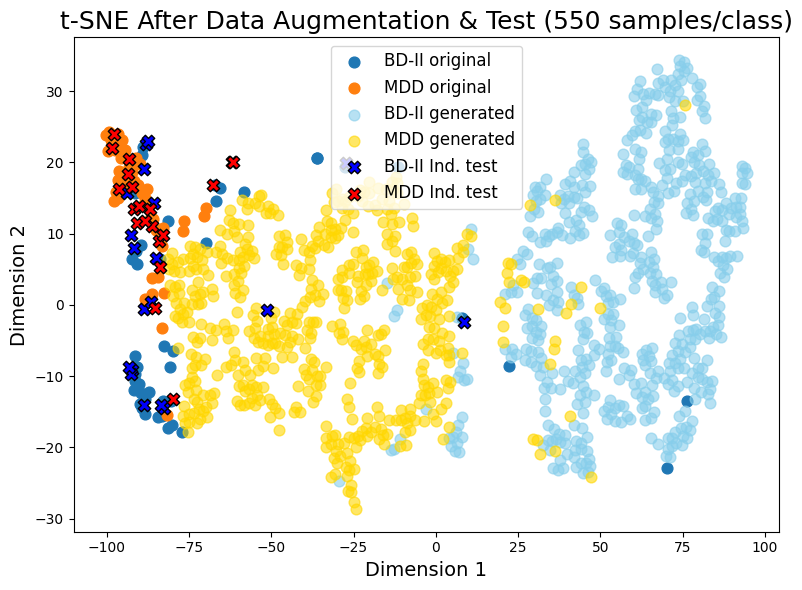

In [27]:
X_aug_best = np.vstack([X_train_final, s0, s1])
y_aug_best = np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
X_tsne_input = np.vstack([X_aug_best, X_test_final])
y_tsne_input = np.concatenate([y_aug_best, y_test])


# Tsne2 = TSNE(n_components=2, random_state=42)
Tsne2 = TSNE(
    n_components=2,
    perplexity=20,
    learning_rate=150,
    early_exaggeration=12,
    n_iter=2000,
    n_iter_without_progress=500,
    min_grad_norm=1e-7,
    metric='cosine',
    init='random',
    method='barnes_hut',
    angle=0.3,
    random_state=42,
    verbose=1
)
X_tsne2 = Tsne2.fit_transform(X_tsne_input)


fig_tsne2, ax_tsne2 = plt.subplots(figsize=(8,6))
colors_train = {'BD_orig':'tab:blue', 'BD_syn':'skyblue', 'MDD_orig':'tab:orange', 'MDD_syn':'gold'}

n_train = len(y_train)
n_syn = 2 * r_best


start, end = 0, n_train
for label, marker, key, label_name in zip([
    0, 1
], ['o','o'], ['BD_orig','MDD_orig'], ['BD-II original','MDD original']):
    idx = (y_train == label)
    pts = X_tsne2[start:end][idx]
    ax_tsne2.scatter(pts[:,0], pts[:,1], label=label_name,
                     marker=marker, s=60, color=colors_train[key])


start, end = n_train, n_train + n_syn
for label, marker, key, label_name in zip([
    0, 1
], ['o','o'], ['BD_syn','MDD_syn'], ['BD-II generated','MDD generated']):
    syn_labels = y_aug_best[start:end]
    idx = (syn_labels == label)
    pts = X_tsne2[start:end][idx]
    ax_tsne2.scatter(pts[:,0], pts[:,1], label=label_name,
                     marker=marker, s=60, color=colors_train[key], alpha=0.6)


start, end = n_train + n_syn, n_train + n_syn + len(y_test)
for label, color, label_name in zip([0,1], ['blue','red'], ['BD-II Ind. test','MDD Ind. test']):
    test_labels = y_tsne_input[start:end]
    idx = (test_labels == label)
    pts = X_tsne2[start:end][idx]
    ax_tsne2.scatter(pts[:,0], pts[:,1], label=label_name,
                     marker='X', s=80, edgecolor='k', facecolor=color)

ax_tsne2.set_title(f"t-SNE After Data Augmentation & Test ({r_best} samples/class)", fontsize=18)
ax_tsne2.set_xlabel("Dimension 1", fontsize=14)
ax_tsne2.set_ylabel("Dimension 2", fontsize=14)
ax_tsne2.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/tsne_after_with_train_test.png")

##### Ind. test distribution

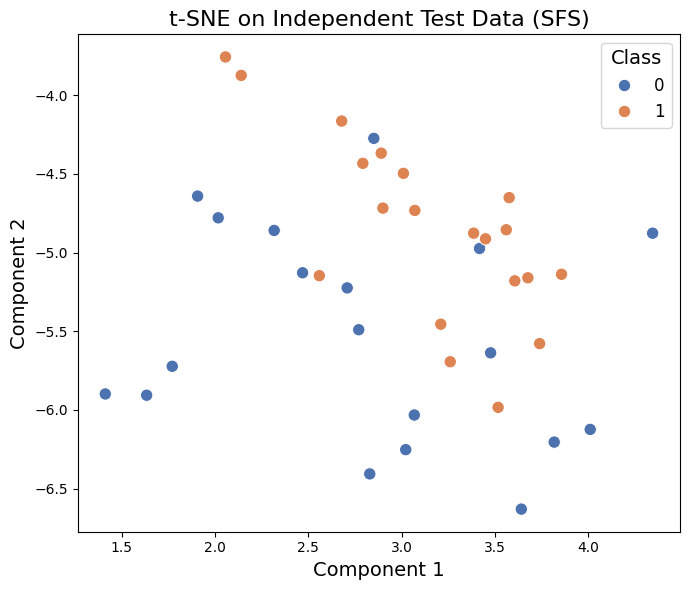

In [27]:
tsne_test = TSNE(n_components=2, random_state=42)
X_tsne_test = tsne_test.fit_transform(X_test_final)
plt.figure(figsize=(7,6))
sns.scatterplot(x=X_tsne_test[:,0], y=X_tsne_test[:,1], 
                hue=y_test.astype(int), palette="deep", s=80)
plt.title("t-SNE on Independent Test Data (SFS)", fontsize=16)
plt.xlabel("Component 1", fontsize=14)
plt.ylabel("Component 2", fontsize=14)
plt.legend(title="Class", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.savefig("tsne_independent_test.png", dpi=300)
plt.show()